# Библиотеки

In [1]:
from zlib import crc32

import numpy as np
import pandas as pd
import scipy.stats as st
import itertools

In [2]:
!pip install cryptorandom permute arch

     |████████████████████████████████| 154 kB 12.6 MB/s 
     |████████████████████████████████| 902 kB 33.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.6 MB/s 
     |████████████████████████████████| 9.8 MB 10.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
! pip install permutation_test

  Created wheel for permutation-test: filename=permutation_test-0.18-py3-none-any.whl size=17053 sha256=c7811329e2268ba7a88fb0fc5365175bc5955df95f304890b67f747a1d2ba24b
  Stored in directory: /root/.cache/pip/wheels/f8/63/17/999c7b1c8f35dd38cc98af0190502c61d0855204399ea83d57
Successfully built permutation-test


In [2]:
from statsmodels.stats.descriptivestats import sign_test
from permute.core import one_sample
from arch.bootstrap import IIDBootstrap

from permutation_test import permutationtest

# Код генерации выборки

In [3]:
import re
EMAIL_REGEX = re.compile(r"[^@]+@phystech.edu")

def generate_dataset(code):
    rs = np.random.RandomState(code%(2**32-1))
    ars = np.random.RandomState(code%(2**16-1))
    if rs.randint(low=0, high=2) == 0:
        while True:
            data = rs.randn(20)
            if st.shapiro(data)[1] > 0.2 or ars.binomial(100, 0.05) > 10:
                break
    else:
        while True:
            data = np.concatenate([rs.randn(6) - 2, rs.randn(6) + 2])
            if st.shapiro(data)[1] < 0.01 or ars.binomial(100, 0.05) > 10:
                break
    return data

# Генерация выборки для вашей почты

<span style="color:red">
    ВАЖНО!
    Почта, которую укажете ниже и почта с которой Вы отправляете домашнее задание должна совпадать!
    В момент проверки задания алгоритм генерирует выборку на основе почты из анкеты!
</span>

Внимательно проверьте почту для которой выполняется задание!

In [4]:
task = dict()
task['mail'] = input(prompt='Enter your mail: ')
assert EMAIL_REGEX.match(task['mail']), 'Not a mail in the phystech.edu domain'
task['id'] = crc32(task['mail'].encode('utf-8'))
task['data'] = generate_dataset(task['id'])

task
#  yurchenko.aa@phystech.edu

Enter your mail: a.alchymbaev@phystech.edu


{'data': array([-0.8606374 , -2.54943463, -0.81654423, -1.69522766, -0.51764971,
         0.55843156, -0.7357619 , -0.68376009,  1.67143183,  0.31316367,
         0.08206509, -0.73368289,  0.82470466,  0.35393625, -0.96380016,
        -0.20120243, -1.10561882,  0.44157839, -2.02790804,  0.30940767]),
 'id': 3795091167,
 'mail': 'a.alchymbaev@phystech.edu'}

# Работа с выборкой

In [21]:
data = task['data']
print(data.shape)
print(data)

(20,)
[-0.8606374  -2.54943463 -0.81654423 -1.69522766 -0.51764971  0.55843156
 -0.7357619  -0.68376009  1.67143183  0.31316367  0.08206509 -0.73368289
  0.82470466  0.35393625 -0.96380016 -0.20120243 -1.10561882  0.44157839
 -2.02790804  0.30940767]


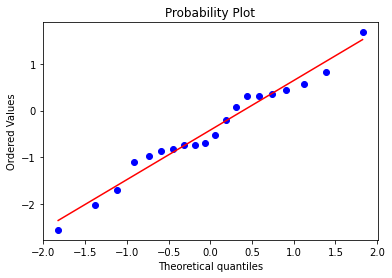

In [22]:
import pylab
st.probplot(data, dist="norm", plot=pylab)
pylab.show()

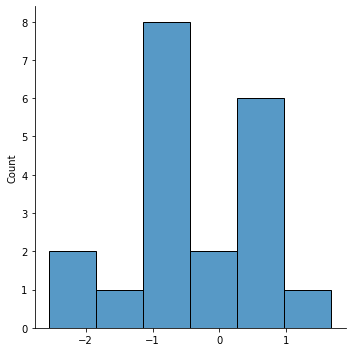

In [23]:
import seaborn as sns
sns.displot(data)
None

In [24]:
print('p_value = {}'.format(st.shapiro(data)[1]))

p_value = 0.89033043384552


$p \_ value > 0.05 ⇒ $ не отклоняем гипотезу о нормальности, можно применять критерий Стьюдента

In [25]:
st.ttest_1samp(data, 0) 

Ttest_1sampResult(statistic=-1.8292072276671871, pvalue=0.08310832871106244)

In [26]:
st.normaltest(data) # альтернативный вариант проверки на нормальность

NormaltestResult(statistic=0.21411406967345117, pvalue=0.8984744271866647)

In [27]:
st.wilcoxon(data) # критерий знаковых рангов Уилкоксона

WilcoxonResult(statistic=57.0, pvalue=0.0758514404296875)

In [28]:
from statsmodels.stats.descriptivestats import sign_test
sign_test(data, mu0=0.0) # критерий знаков

(-2.0, 0.5034446716308594)

In [29]:
2**data.shape[0] # число перестановок

1048576

In [40]:
t = (data - 0.5)
T = np.sum(t)
count = 0
good = 0
for v in itertools.product([-1, 1], repeat=data.shape[0]):
    count += 1
    stat = np.dot(t, v)
    #if abs(stat)<=abs(T):
    if stat<=T:
        good+=1
    
print(good/count)      
print('good_count =', good) # количество перестановок, когда статистика имеет значение меньшее или равное статистике для оригинальной выборки

0.00033283233642578125
good_count = 349


In [31]:
bs = IIDBootstrap(data) 
bound = list(map(lambda x: round(x[0], 2), bs.conf_int(np.mean, 10000, method='basic')))
print('left_bound = {}\nright_bound = {}'.format(*bound)) # левая и правая границы доверительного интервала для среднего выборки 

left_bound = -0.85
right_bound = 0.02


In [33]:
bound

[-0.85, 0.02]

In [32]:
rs = np.random.RandomState(0) # бутстреп вручную

idx = rs.randint(low=0, high=data.shape[0], size=(10000, data.shape[0]))
results = []
for i in idx:
    sample = data[i]
    results.append(sample.mean())

np.percentile(results, [2.5, 97.5])

array([-0.85489286,  0.01331223])